In [6]:
import os
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as tf
import torchvision

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random

In [ ]:

device = 'cpu'
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

CACHE_DIR = './data/imagenet_inversion'
RESNET_SIZE = 224
TARGET_CROP = torchvision.transforms.CenterCrop((36, 64))

class CachedImageNet(ImageNet):
    def __init__(self, root, split, transform=None, feature_extractor=None, version='0.1'):
        super().__init__(root=root, split=split, transform=transform)
        self.feature_extractor = feature_extractor  # Function to extract features
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]


    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        # Cache file path
        cache_path = self._get_cache_path(index)

        # Load feature from cache if it exists

        img = img.unsqueeze(0)  # Add batch dimension
        grayscale_img_rgb = F.rgb_to_grayscale(img, num_output_channels=3)  # Convert to grayscale [1, H, W]
        features_path = os.path.join(self.cache_dir, f'feature_{index}.pt')

        if os.path.exists(cache_path):
            saved_features = torch.load(cache_path)
            if random() < 0.01: # check if the cache is correct
                features = None
                def assign_features(module, input, output):
                    nonlocal features
                    features = output
                hook = self.resnet_layer.register_forward_hook(assign_features)
                
                with torch.no_grad():
                    self.resnet50(grayscale_img_rgb)
                hook.remove()
                assert features is not None
                assert torch.equal(saved_features, features)
            features = saved_features

        else:
            # Compute feature if not cached

            features = None
            def assign_features(module, input, output):
                nonlocal features
                features = output
            hook = self.resnet_layer.register_forward_hook(assign_features)
            
            with torch.no_grad():
                self.resnet50(grayscale_img_rgb)
            hook.remove()
            assert features is not None

            torch.save(features, cache_path)  # Save to cache
        
        # center crop
        target = TARGET_CROP(F.rgb_to_grayscale(img, num_output_channels=1))
        return grayscale_img_rgb, features, target
# Image transformations
train_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Example feature extractor: compute mean/std per channel

def feature_extractor(img):
    img_np = np.array(img)
    mean = np.mean(img_np, axis=(0, 1))
    std = np.std(img_np, axis=(0, 1))
    return torch.tensor(np.concatenate([mean, std]))
# Dataset path

data_dir = 'data/imagenet'

# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=data_dir,
    split='val',
    transform=train_transforms,
    feature_extractor=feature_extractor,
    version='0.3'
)

from torch.utils.data import random_split, DataLoader

# Define the split sizes
train_size = int(0.8 * len(train_dataset))  # 80% for training
test_size = len(train_dataset) - train_size  # 20% for testing
print("Train size:", train_size)
print("Test size:", test_size)

# Split the dataset
train_subset, test_subset = random_split(train_dataset, [train_size, test_size])

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=64,
    # shuffle=True,
    shuffle=False,
    num_workers=1
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=64,
    shuffle=False,  # No need to shuffle test data
    num_workers=1
)


Using cache found in /home/miki/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/miki/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/miki/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
Using cache found in /home/miki/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train size: 40000
Test size: 10000


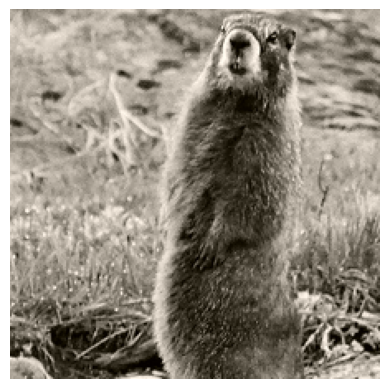

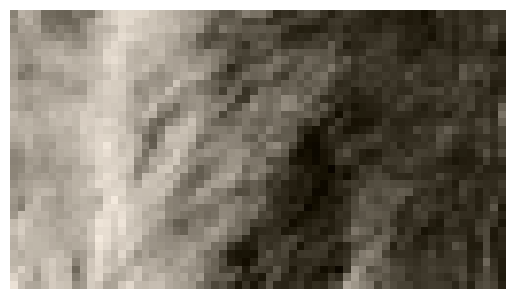

In [8]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))  # Convert to HWC
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet normalization mean
    std = np.array([0.229, 0.224, 0.225])  # ImageNet normalization std
    img = std * img + mean  # De-normalize
    img = np.clip(img, 0, 1)  # Clip values to [0, 1]
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
images, features, targets = next(data_iter)
show_image(images[2][0, ...])  # Show the first image in the batch
show_image(targets[2][0, ...])  # Show the first image in the batch

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as f2

class LogisticRegressor(nn.Module):
    def __init__(self, feature_dim, output_dim):
        """
        Logistic Regression Model
        :param feature_dim: Flattened input feature size
        :param output_dim: Number of outputs (1 for binary classification)
        """
        super(LogisticRegressor, self).__init__()
        self.linear = nn.Linear(feature_dim, output_dim)
        
    def forward(self, x):
        logits = self.linear(x)  # Compute raw scores
        probs = torch.sigmoid(logits)  # Apply sigmoid for binary classification
        return probs
class SingleLayerMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, alpha=1.0):
        """
        Single-layer MLP for regression.
        :param input_dim: Input feature size (flattened)
        :param hidden_dim: Number of hidden units
        :param output_dim: Number of outputs (target size)
        :param alpha: Regularization strength
        """
        super(SingleLayerMLP, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.alpha = alpha

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        return self.output(x)

# Model parameters
batch_size = 64
feature_shape = (1024, 14, 14)  # Provided feature shape
flattened_feature_size = torch.prod(torch.tensor(feature_shape)).item()

output_size = 36 * 64  # Flattened target shape (36x64 from TARGET_CROP)
# Model parameters
hidden_units = 64 # Number of hidden units in the MLP
mlp_model = SingleLayerMLP(flattened_feature_size, hidden_units, output_size, alpha=1.0).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Training Loop
num_epochs = 1  # Number of epochs
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    mlp_model.train()
    running_loss = 0.0

    for grayscale_img, features, target in tqdm(train_loader):
        features = features.to(device)  # Move to device
        target = target.view(target.size(0), -1).to(device)  # Flatten target

        # Flatten features
        features = features.view(features.size(0), -1)

        # Forward pass
        outputs = mlp_model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # constant_guess = torch.mean(target, dim=(-1, -2), keepdim=True)
        constant_guess_loss = criterion(torch.full_like(target, 0), target)
        print(f"Constant guess loss: {constant_guess_loss.item()}")
        print(f"Loss: {loss.item()}")


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
       





  0%|          | 1/625 [00:00<09:45,  1.07it/s]

Constant guess loss: 1.1566643714904785
Loss: 1.1707110404968262


  0%|          | 2/625 [00:02<10:30,  1.01s/it]

Constant guess loss: 1.1285955905914307
Loss: 17.521137237548828


  0%|          | 3/625 [00:02<10:15,  1.01it/s]

Constant guess loss: 1.4989601373672485
Loss: 1.6304831504821777


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0b87fa7910>
Traceback (most recent call last):
  File "/home/miki/epfl/ml_second_project/.conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/miki/epfl/ml_second_project/.conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/miki/epfl/ml_second_project/.conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  1%|          | 4/625 [00:04<10:38,  1.03s/it]

Constant guess loss: 1.2220410108566284
Loss: 3.560964822769165


  1%|          | 5/625 [00:05<11:10,  1.08s/it]

Constant guess loss: 1.305487036705017
Loss: 1.3094035387039185


  1%|          | 6/625 [00:06<11:12,  1.09s/it]

Constant guess loss: 1.3431347608566284
Loss: 1.3466601371765137


  1%|          | 7/625 [00:07<10:21,  1.01s/it]

Constant guess loss: 1.256549596786499
Loss: 1.2597962617874146


  1%|▏         | 8/625 [00:08<10:04,  1.02it/s]

Constant guess loss: 1.410298228263855
Loss: 1.4146943092346191


  1%|▏         | 9/625 [00:08<09:22,  1.10it/s]

Constant guess loss: 1.271242618560791
Loss: 1.275247573852539


  2%|▏         | 10/625 [00:09<08:48,  1.16it/s]

Constant guess loss: 1.220329761505127
Loss: 1.2246432304382324


  2%|▏         | 11/625 [00:10<10:16,  1.00s/it]

Constant guess loss: 1.5379712581634521
Loss: 1.542762041091919


  2%|▏         | 12/625 [00:11<09:41,  1.05it/s]

Constant guess loss: 1.1062324047088623
Loss: 1.110217571258545


  2%|▏         | 13/625 [00:13<11:34,  1.13s/it]

Constant guess loss: 1.5697368383407593
Loss: 1.5743519067764282


  2%|▏         | 14/625 [00:14<10:13,  1.00s/it]

Constant guess loss: 1.457221508026123
Loss: 1.462213158607483


  2%|▏         | 15/625 [00:15<10:27,  1.03s/it]

Constant guess loss: 1.3148515224456787
Loss: 1.317934513092041


  3%|▎         | 16/625 [00:15<09:07,  1.11it/s]

Constant guess loss: 1.251760721206665
Loss: 1.2564723491668701


  3%|▎         | 17/625 [00:16<09:12,  1.10it/s]

Constant guess loss: 1.4940844774246216
Loss: 1.4965827465057373


  3%|▎         | 18/625 [00:17<09:16,  1.09it/s]

Constant guess loss: 1.2853894233703613
Loss: 1.289313793182373


  3%|▎         | 19/625 [00:24<26:45,  2.65s/it]

Constant guess loss: 1.3015888929367065
Loss: 1.3067073822021484


  3%|▎         | 20/625 [00:30<37:58,  3.77s/it]

Constant guess loss: 1.107861042022705
Loss: 1.1091197729110718


  3%|▎         | 21/625 [00:36<44:34,  4.43s/it]

Constant guess loss: 1.1672972440719604
Loss: 1.1722636222839355


  4%|▎         | 22/625 [00:43<51:08,  5.09s/it]

Constant guess loss: 1.3300554752349854
Loss: 1.3334287405014038


  4%|▎         | 23/625 [00:49<54:47,  5.46s/it]

Constant guess loss: 1.2367457151412964
Loss: 1.2413383722305298


  4%|▍         | 24/625 [00:55<57:20,  5.72s/it]

Constant guess loss: 1.4886584281921387
Loss: 1.493335247039795


  4%|▍         | 25/625 [01:02<59:38,  5.96s/it]

Constant guess loss: 1.313102126121521
Loss: 1.3168784379959106


  4%|▍         | 26/625 [01:08<1:00:03,  6.02s/it]

Constant guess loss: 1.2658511400222778
Loss: 1.269430160522461


  4%|▍         | 27/625 [01:14<59:59,  6.02s/it]  

Constant guess loss: 1.362252950668335
Loss: 1.3660812377929688


  4%|▍         | 28/625 [01:21<1:01:16,  6.16s/it]

Constant guess loss: 1.3305250406265259
Loss: 1.3368120193481445


  5%|▍         | 29/625 [01:27<1:02:09,  6.26s/it]

Constant guess loss: 1.1365199089050293
Loss: 1.1407899856567383


  5%|▍         | 30/625 [01:33<1:02:24,  6.29s/it]

Constant guess loss: 1.4748005867004395
Loss: 1.4764900207519531


  5%|▍         | 31/625 [01:40<1:03:00,  6.36s/it]

Constant guess loss: 1.1608068943023682
Loss: 1.1654417514801025


  5%|▌         | 32/625 [01:46<1:03:22,  6.41s/it]

Constant guess loss: 1.1587352752685547
Loss: 1.164675235748291


  5%|▌         | 33/625 [01:53<1:04:36,  6.55s/it]

Constant guess loss: 1.5654488801956177
Loss: 1.571631908416748


  5%|▌         | 34/625 [02:00<1:05:07,  6.61s/it]

Constant guess loss: 1.2784616947174072
Loss: 1.2827128171920776


  6%|▌         | 35/625 [02:07<1:05:59,  6.71s/it]

Constant guess loss: 1.2276418209075928
Loss: 1.229737401008606


  6%|▌         | 36/625 [02:14<1:06:26,  6.77s/it]

Constant guess loss: 1.378411054611206
Loss: 1.3826216459274292


  6%|▌         | 37/625 [02:21<1:07:00,  6.84s/it]

Constant guess loss: 1.317308783531189
Loss: 1.3204909563064575


  6%|▌         | 38/625 [02:27<1:05:40,  6.71s/it]

Constant guess loss: 1.0375473499298096
Loss: 1.0397460460662842


  6%|▌         | 39/625 [02:34<1:06:00,  6.76s/it]

Constant guess loss: 1.2833669185638428
Loss: 1.288133144378662


  6%|▋         | 40/625 [02:41<1:06:58,  6.87s/it]

Constant guess loss: 1.357363224029541
Loss: 1.3600926399230957


  7%|▋         | 41/625 [02:48<1:07:24,  6.93s/it]

Constant guess loss: 1.3770209550857544
Loss: 1.3803908824920654


  7%|▋         | 42/625 [02:55<1:06:08,  6.81s/it]

Constant guess loss: 1.3368314504623413
Loss: 1.3405499458312988


  7%|▋         | 43/625 [03:03<1:08:51,  7.10s/it]

Constant guess loss: 1.4259276390075684
Loss: 1.4289659261703491


  7%|▋         | 44/625 [03:11<1:11:45,  7.41s/it]

Constant guess loss: 1.192384123802185
Loss: 1.1954437494277954


  7%|▋         | 45/625 [03:19<1:13:03,  7.56s/it]

Constant guess loss: 1.2803701162338257
Loss: 1.2843658924102783


  7%|▋         | 46/625 [03:26<1:12:56,  7.56s/it]

Constant guess loss: 1.3492379188537598
Loss: 1.3491578102111816


  8%|▊         | 47/625 [03:34<1:12:23,  7.51s/it]

Constant guess loss: 1.330204725265503
Loss: 1.3338326215744019


  8%|▊         | 48/625 [03:41<1:11:38,  7.45s/it]

Constant guess loss: 1.2210439443588257
Loss: 1.2254406213760376


  8%|▊         | 49/625 [03:48<1:10:13,  7.32s/it]

Constant guess loss: 1.2527681589126587
Loss: 1.2570741176605225


  8%|▊         | 50/625 [03:54<1:07:36,  7.06s/it]

Constant guess loss: 1.2082563638687134
Loss: 1.211907148361206


  8%|▊         | 51/625 [04:01<1:06:58,  7.00s/it]

Constant guess loss: 1.4281671047210693
Loss: 1.43361496925354


  8%|▊         | 52/625 [04:08<1:06:30,  6.96s/it]

Constant guess loss: 1.3858191967010498
Loss: 1.3900926113128662


  8%|▊         | 53/625 [04:15<1:05:17,  6.85s/it]

Constant guess loss: 1.284321665763855
Loss: 1.2828749418258667


  9%|▊         | 54/625 [04:22<1:04:52,  6.82s/it]

Constant guess loss: 1.1800484657287598
Loss: 1.182605266571045


  9%|▉         | 55/625 [04:29<1:05:13,  6.87s/it]

Constant guess loss: 1.4824265241622925
Loss: 1.4855319261550903


  9%|▉         | 56/625 [04:35<1:04:47,  6.83s/it]

Constant guess loss: 1.301115870475769
Loss: 1.3017739057540894


  9%|▉         | 57/625 [04:42<1:04:01,  6.76s/it]

Constant guess loss: 1.2876102924346924
Loss: 1.2856132984161377


  9%|▉         | 58/625 [04:49<1:04:13,  6.80s/it]

Constant guess loss: 1.2534315586090088
Loss: 1.2549262046813965


  9%|▉         | 59/625 [04:55<1:02:23,  6.61s/it]

Constant guess loss: 1.1872897148132324
Loss: 1.1905264854431152


 10%|▉         | 60/625 [05:01<1:01:31,  6.53s/it]

Constant guess loss: 1.0797492265701294
Loss: 1.07900071144104


 10%|▉         | 61/625 [05:09<1:04:57,  6.91s/it]

Constant guess loss: 1.44990873336792
Loss: 1.4490917921066284


 10%|▉         | 62/625 [05:16<1:04:33,  6.88s/it]

Constant guess loss: 1.2723287343978882
Loss: 1.274540662765503


 10%|█         | 63/625 [05:23<1:05:29,  6.99s/it]

Constant guess loss: 1.411981463432312
Loss: 1.4115709066390991


 10%|█         | 64/625 [05:30<1:03:53,  6.83s/it]

Constant guess loss: 1.6121575832366943
Loss: 1.6235581636428833


 10%|█         | 65/625 [05:37<1:04:43,  6.93s/it]

Constant guess loss: 1.207374095916748
Loss: 1.2118799686431885


 11%|█         | 66/625 [05:44<1:05:13,  7.00s/it]

Constant guess loss: 1.441182017326355
Loss: 1.445251703262329


 11%|█         | 67/625 [05:51<1:05:14,  7.01s/it]

Constant guess loss: 1.2206825017929077
Loss: 1.2222752571105957


 11%|█         | 68/625 [05:57<1:03:16,  6.82s/it]

Constant guess loss: 1.2406713962554932
Loss: 1.2444815635681152


 11%|█         | 69/625 [06:04<1:03:12,  6.82s/it]

Constant guess loss: 1.0575058460235596
Loss: 1.0588366985321045


 11%|█         | 70/625 [06:11<1:03:03,  6.82s/it]

Constant guess loss: 1.3629251718521118
Loss: 1.3690012693405151


 11%|█▏        | 71/625 [06:18<1:02:29,  6.77s/it]

Constant guess loss: 1.3728737831115723
Loss: 1.3754838705062866


 12%|█▏        | 72/625 [06:24<1:02:19,  6.76s/it]

Constant guess loss: 1.3011215925216675
Loss: 1.300714373588562


 12%|█▏        | 73/625 [06:31<1:03:04,  6.86s/it]

Constant guess loss: 1.5357879400253296
Loss: 1.5296427011489868


 12%|█▏        | 74/625 [06:38<1:03:03,  6.87s/it]

Constant guess loss: 1.3650411367416382
Loss: 1.3731056451797485


 12%|█▏        | 75/625 [06:46<1:05:17,  7.12s/it]

Constant guess loss: 1.1145360469818115
Loss: 1.116494059562683


 12%|█▏        | 76/625 [06:53<1:05:50,  7.20s/it]

Constant guess loss: 1.3115954399108887
Loss: 1.3099027872085571


 12%|█▏        | 77/625 [07:00<1:04:15,  7.04s/it]

Constant guess loss: 1.4347481727600098
Loss: 1.440680742263794


 12%|█▏        | 78/625 [07:07<1:03:03,  6.92s/it]

Constant guess loss: 1.338387131690979
Loss: 1.3427636623382568


 13%|█▎        | 79/625 [07:13<1:02:15,  6.84s/it]

Constant guess loss: 1.2822185754776
Loss: 1.2832757234573364


 13%|█▎        | 80/625 [07:20<1:01:23,  6.76s/it]

Constant guess loss: 1.3147553205490112
Loss: 1.3171730041503906


 13%|█▎        | 81/625 [07:27<1:00:38,  6.69s/it]

Constant guess loss: 1.2460776567459106
Loss: 1.2438488006591797


 13%|█▎        | 82/625 [07:33<58:59,  6.52s/it]  

Constant guess loss: 1.3396706581115723
Loss: 1.3432706594467163


 13%|█▎        | 83/625 [07:39<58:46,  6.51s/it]

Constant guess loss: 1.0588206052780151
Loss: 1.0584903955459595


 13%|█▎        | 84/625 [07:45<58:19,  6.47s/it]

Constant guess loss: 1.4658974409103394
Loss: 1.4646632671356201


 14%|█▎        | 85/625 [07:52<59:32,  6.61s/it]

Constant guess loss: 1.245115876197815
Loss: 1.2457510232925415


 14%|█▍        | 86/625 [07:59<58:54,  6.56s/it]

Constant guess loss: 1.342877984046936
Loss: 1.3462812900543213


 14%|█▍        | 87/625 [08:05<58:34,  6.53s/it]

Constant guess loss: 1.508251667022705
Loss: 1.5077672004699707


 14%|█▍        | 88/625 [08:12<58:52,  6.58s/it]

Constant guess loss: 1.2229013442993164
Loss: 1.2237879037857056


 14%|█▍        | 89/625 [08:19<59:47,  6.69s/it]

Constant guess loss: 1.5091856718063354
Loss: 1.51106858253479


 14%|█▍        | 90/625 [08:26<1:00:05,  6.74s/it]

Constant guess loss: 1.362927794456482
Loss: 1.3653087615966797


 15%|█▍        | 91/625 [08:33<1:01:18,  6.89s/it]

Constant guess loss: 1.3454984426498413
Loss: 1.3482216596603394


 15%|█▍        | 92/625 [08:41<1:02:55,  7.08s/it]

Constant guess loss: 1.3186309337615967
Loss: 1.3219529390335083


 15%|█▍        | 93/625 [08:49<1:06:20,  7.48s/it]

Constant guess loss: 1.3183341026306152
Loss: 1.325556993484497


 15%|█▌        | 94/625 [08:57<1:06:42,  7.54s/it]

Constant guess loss: 1.265428066253662
Loss: 1.2659887075424194


 15%|█▌        | 95/625 [09:04<1:06:43,  7.55s/it]

Constant guess loss: 1.4499431848526
Loss: 1.4474563598632812


 15%|█▌        | 96/625 [09:11<1:03:56,  7.25s/it]

Constant guess loss: 1.1588568687438965
Loss: 1.1624093055725098


 16%|█▌        | 97/625 [09:18<1:03:31,  7.22s/it]

Constant guess loss: 1.4871524572372437
Loss: 1.4890586137771606


 16%|█▌        | 98/625 [09:24<1:00:57,  6.94s/it]

Constant guess loss: 1.221335530281067
Loss: 1.222093939781189


 16%|█▌        | 99/625 [09:31<59:33,  6.79s/it]  

Constant guess loss: 1.2671997547149658
Loss: 1.270882248878479


 16%|█▌        | 100/625 [09:36<56:34,  6.47s/it]

Constant guess loss: 1.4348089694976807
Loss: 1.4392105340957642


 16%|█▌        | 101/625 [09:43<56:26,  6.46s/it]

Constant guess loss: 1.1955821514129639
Loss: 1.1971611976623535


 16%|█▋        | 102/625 [09:49<55:40,  6.39s/it]

Constant guess loss: 1.2214215993881226
Loss: 1.2235995531082153


 16%|█▋        | 103/625 [09:56<56:06,  6.45s/it]

Constant guess loss: 1.3238143920898438
Loss: 1.3318829536437988


 17%|█▋        | 104/625 [10:02<56:54,  6.55s/it]

Constant guess loss: 1.4366551637649536
Loss: 1.4423986673355103


 17%|█▋        | 105/625 [10:09<56:05,  6.47s/it]

Constant guess loss: 1.4526125192642212
Loss: 1.4577910900115967


 17%|█▋        | 106/625 [10:15<55:38,  6.43s/it]

Constant guess loss: 1.26603364944458
Loss: 1.2667391300201416


 17%|█▋        | 107/625 [10:21<54:10,  6.28s/it]

Constant guess loss: 1.1363606452941895
Loss: 1.1357321739196777


 17%|█▋        | 108/625 [10:26<51:28,  5.97s/it]

Constant guess loss: 1.3430317640304565
Loss: 1.3417009115219116


 17%|█▋        | 109/625 [10:32<51:49,  6.03s/it]

Constant guess loss: 1.5053547620773315
Loss: 1.5023547410964966


 18%|█▊        | 110/625 [10:40<55:21,  6.45s/it]

Constant guess loss: 1.2494484186172485
Loss: 1.2524380683898926


 18%|█▊        | 111/625 [10:47<56:18,  6.57s/it]

Constant guess loss: 1.303115725517273
Loss: 1.3029752969741821


 18%|█▊        | 112/625 [10:55<59:23,  6.95s/it]

Constant guess loss: 1.413284420967102
Loss: 1.412274718284607


 18%|█▊        | 113/625 [11:02<1:00:33,  7.10s/it]

Constant guess loss: 1.264707088470459
Loss: 1.2597187757492065


 18%|█▊        | 114/625 [11:09<59:34,  6.99s/it]  

Constant guess loss: 1.3514775037765503
Loss: 1.3477106094360352


 18%|█▊        | 115/625 [11:16<59:27,  6.99s/it]

Constant guess loss: 1.327447533607483
Loss: 1.3267338275909424


 19%|█▊        | 116/625 [11:23<59:37,  7.03s/it]

Constant guess loss: 1.3751327991485596
Loss: 1.3820147514343262


 19%|█▊        | 117/625 [11:29<57:33,  6.80s/it]

Constant guess loss: 1.4902310371398926
Loss: 1.494774341583252


 19%|█▉        | 118/625 [11:36<57:42,  6.83s/it]

Constant guess loss: 1.3226332664489746
Loss: 1.3206721544265747


 19%|█▉        | 119/625 [11:42<56:21,  6.68s/it]

Constant guess loss: 1.168717861175537
Loss: 1.1713122129440308


 19%|█▉        | 120/625 [11:49<55:22,  6.58s/it]

Constant guess loss: 1.2267848253250122
Loss: 1.232895016670227


 19%|█▉        | 121/625 [11:56<58:10,  6.92s/it]

Constant guess loss: 1.4562668800354004
Loss: 1.4574514627456665


 20%|█▉        | 122/625 [12:04<1:00:40,  7.24s/it]

Constant guess loss: 1.3964074850082397
Loss: 1.3983635902404785


 20%|█▉        | 122/625 [12:10<50:11,  5.99s/it]  


KeyboardInterrupt: 

 10%|▉         | 15/157 [01:46<16:48,  7.11s/it]


Test Loss (First 10%): 1.3236


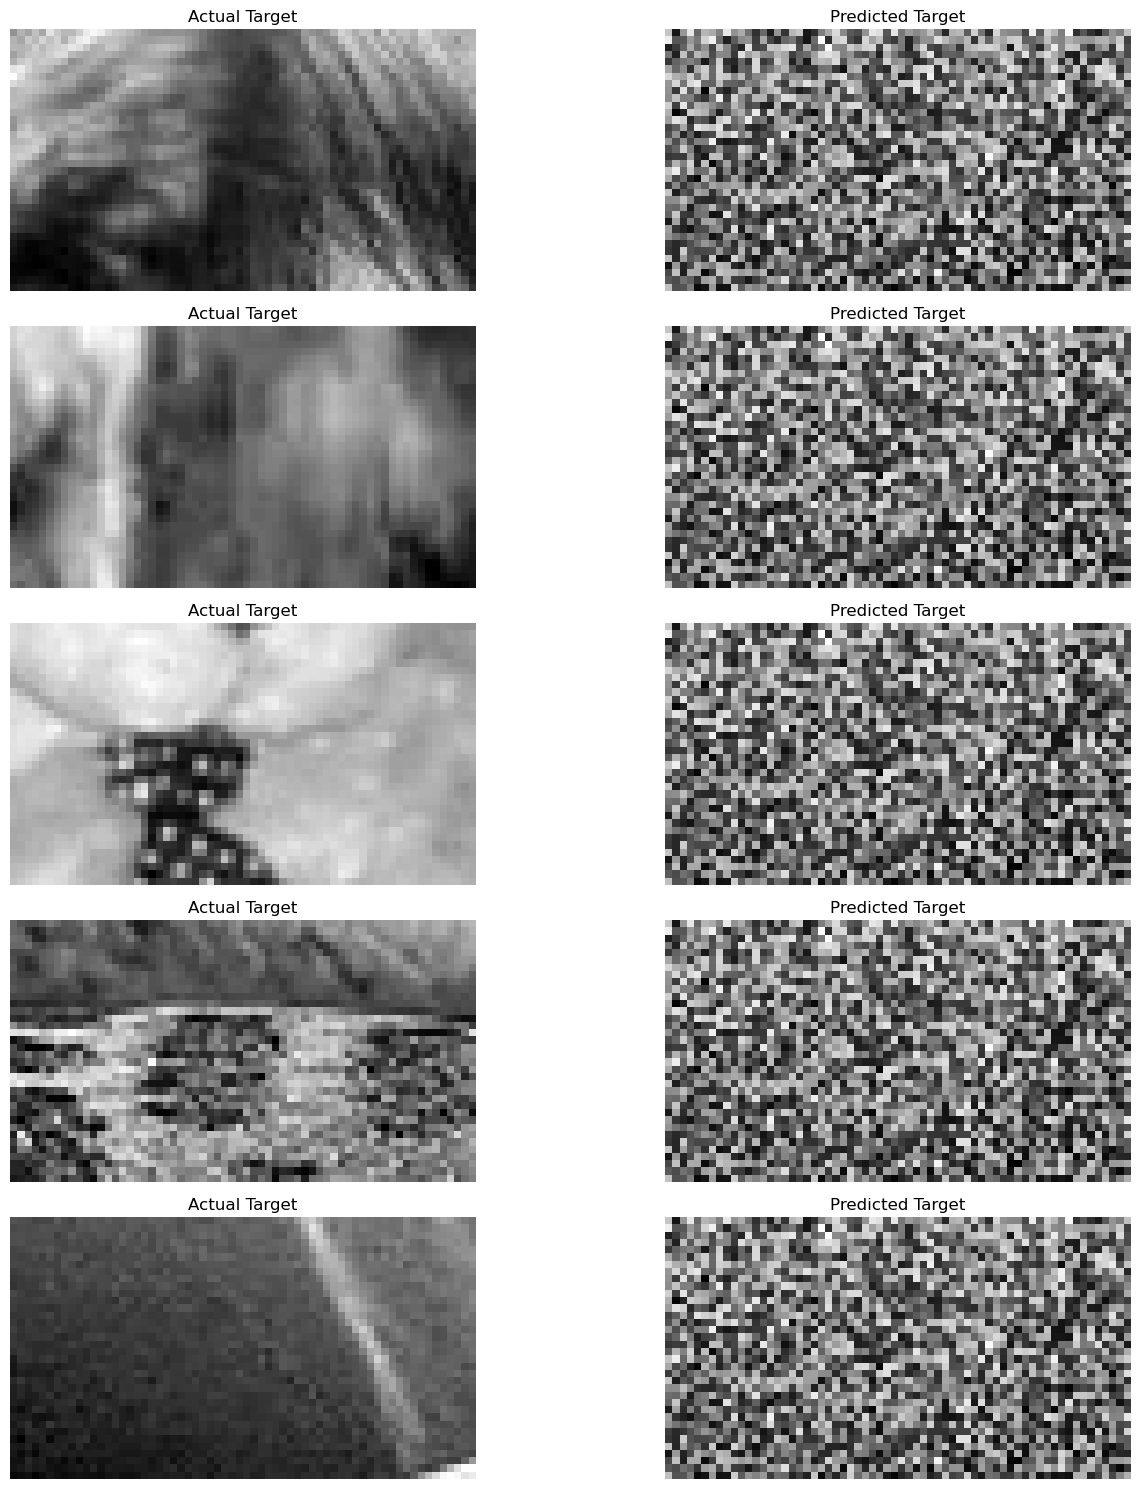

In [15]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, percentage=0.1):
    model.eval()
    test_loss = 0.0
    criterion = nn.MSELoss()
    all_targets = []
    all_predictions = []

    num_batches = int(len(test_loader) * percentage)  # Calculate the number of batches to process
    processed_batches = 0

    with torch.no_grad():
        for grayscale_img, features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.view(target.size(0), -1).to(device)

            # Flatten features
            features = features.view(features.size(0), -1)

            # Predict
            predictions = model(features)
            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(
    mlp_model, test_loader, device, percentage=0.1
)
print(f"Test Loss (First 10%): {test_loss_partial:.4f}")

# Plot Examples
def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].reshape(36, 64), cmap='gray')
        plt.title("Actual Target")
        plt.axis('off')

        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].reshape(36, 64), cmap='gray')
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].numpy(), partial_predictions[:num_examples].numpy())


In [ ]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-3.8672) tensor(2.8663)
tensor(-2.0337) tensor(2.3987)
